# Path Finding using GA
The original implementation by Morvan Zhou implements a path finding Genetic Algorithm where the chromosomes are sets of $(dx,dy)$ movements on a grid, which are then summed together to give the path taken by the particluar parent. Therefore, the choromosome is $2\times$ `N_MOVES` long, defined as $[dx_1, dx_2, \ldots, dx_t, dy_1, dy_2,\ldots,dy_t]$.

My code below remains the same as that one Morvan Zhou in terms of functionality / algorithm flow. However, I make some interesting changes in the GA algorithm. The changes are summarized below:
1. In the original version, the fitness function is based only on the distance between the end point of the parents and the goal point $(x_g, y_g)$, after `N_MOVES`.
I believe this may lead to "meandering" of the parent and not aid in finding the optimum path. Therefore, I change the fitness function to:
$$fitness = \frac{1}{(\frac{x}{n_{close}+1}+1)^2},\quad\text{where }n_{close}=\text{No. of iterations where the agent is close to the goal}$$
This gives more importance to the solutions which spend more time near the goal point, leading to solutions which move tend to move directly towards the goal, if there are no obstacles around.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
N_MOVES = 300
DNA_SIZE = N_MOVES*2         # 40 x moves, 40 y moves
DIRECTION_BOUND = [0, 1]
CROSS_RATE = 0.8
MUTATE_RATE = 0.001
POP_SIZE = 100
N_GENERATIONS = 700
GOAL_POINT = [10, 5]
START_POINT = [0, -3]
OBSTACLE_LINE = np.array([[[2, 0], [2, 15]], [[5, -15],[5, 2]]])

In [3]:
class GA(object):
    def __init__(self, DNA_size, DNA_bound, cross_rate, mutation_rate, pop_size):
        self.DNA_size = DNA_size
        # DNA_size is a 2*n_noves array, where the first n_moves are the x axis moves and the next n_moves are the y axis moves
        self.DNA_bound = DNA_bound.copy()
        self.DNA_bound[1] += 1 # length of leaps possible in single "step"
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        self.pop = np.random.randint(*self.DNA_bound, size=(pop_size, DNA_size))

    def DNA2product(self, DNA, n_moves, start_point):                 # convert to readable string
        pop = (DNA - 0.5) / 2
        pop[:, 0], pop[:, 1] = start_point[0], start_point[1]
        lines_x = np.cumsum(pop[:,::2], axis=1)
        lines_y = np.cumsum(pop[:,1::2], axis=1)
        return lines_x, lines_y

    def get_fitness(self, lines_x, lines_y, goal_point, obstacle_lines):
        dist2goal = np.sqrt((goal_point[0] - lines_x[:, :]) ** 2 + (goal_point[1] - lines_y[:, :]) ** 2)
        num_close = np.apply_along_axis(lambda x: (x<1.5).sum(), 1, dist2goal)
        cum_dist = dist2goal[:,-1]/(num_close/(self.DNA_size/2)+1)
        fitness = np.power(1 / (cum_dist + 1), 2)
        
        for obs in obstacle_lines:
            points = (lines_x > obs[0, 0] - 0.5) & (lines_x < obs[1, 0] + 0.5)
            y_values = np.where(points, lines_y, np.zeros_like(lines_y) - 100)
            bad_lines = ((y_values > obs[0, 1]) & (y_values < obs[1, 1])).max(axis=1)
            fitness[bad_lines] = 1e-6
        return fitness

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness/fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)  # select another individual from pop
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(bool)   # choose crossover points
            parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                child[point] = np.random.randint(*self.DNA_bound)
        return child

    def evolve(self, fitness):
        pop = self.select(fitness)
        pop_copy = pop.copy()
        for parent in pop:  # for every parent
            child = self.crossover(parent, pop_copy)
            child = self.mutate(child)
            parent[:] = child
        self.pop = pop

In [4]:
class Line(object):
    def __init__(self, n_moves, goal_point, start_point, obstacle_lines):
        self.n_moves = n_moves
        self.goal_point = goal_point
        self.start_point = start_point
        self.obstacle_lines = obstacle_lines
        self.iter=0
        plt.ion()

    def plotting(self, lines_x, lines_y, save=False):
        plt.cla()
        plt.scatter(*self.goal_point, s=200, c='r')
        plt.scatter(*self.start_point, s=100, c='b')
        for obs in self.obstacle_lines:
            plt.plot(obs[:, 0], obs[:, 1], lw=3, c='k')
        plt.plot(lines_x.T, lines_y.T, c='k')
        plt.xlim((-5, 15))
        plt.ylim((-5, 15))
        if save: plt.savefig('Images/path_finding/path_finding_{:03d}'.format(self.iter))
        if self.iter%40==0: plt.show()
        self.iter += 1

In [5]:
env = Line(N_MOVES, GOAL_POINT, START_POINT, OBSTACLE_LINE)

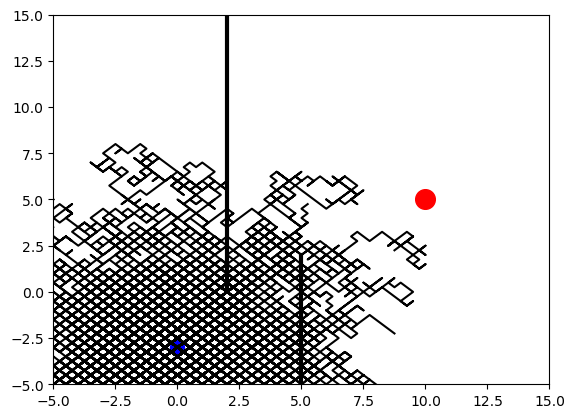

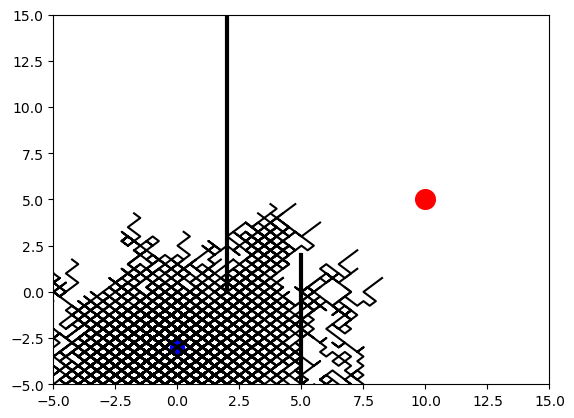

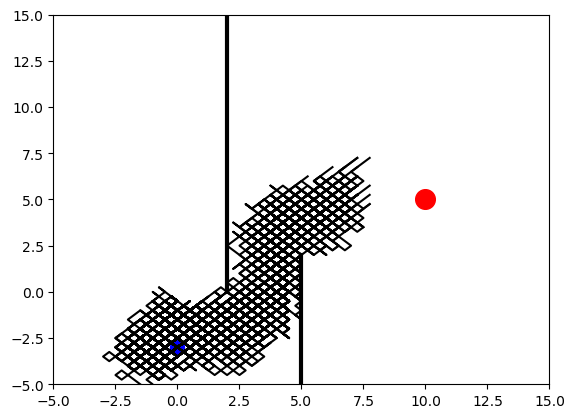

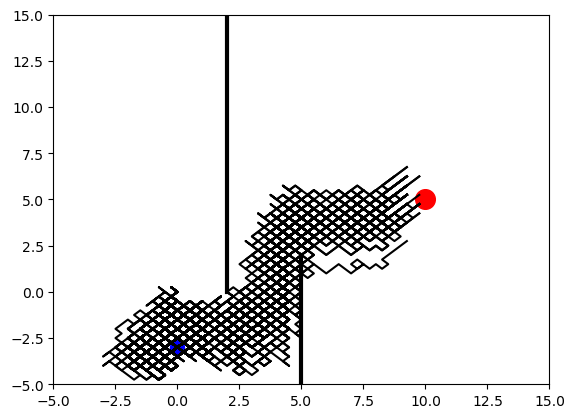

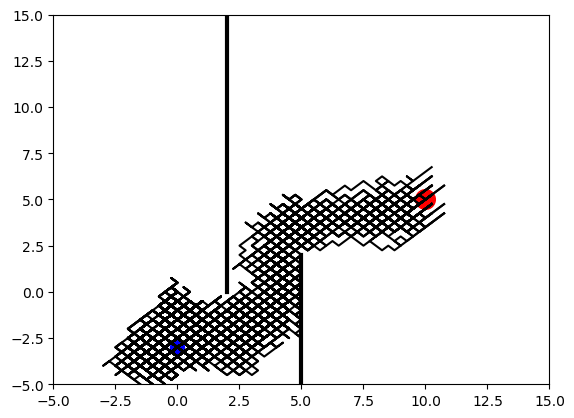

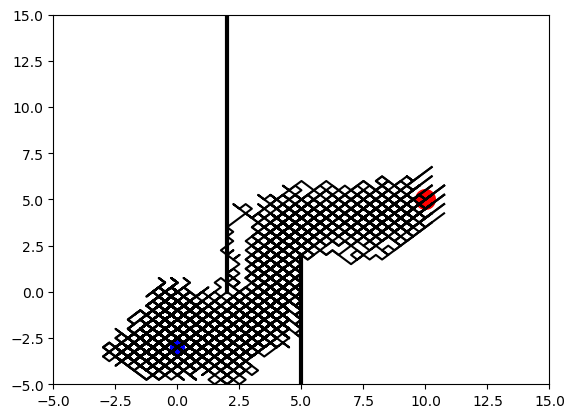

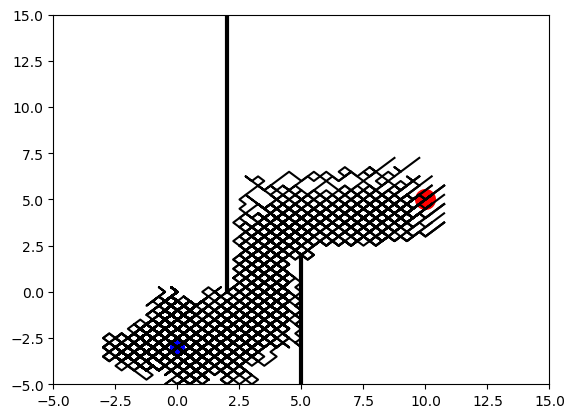

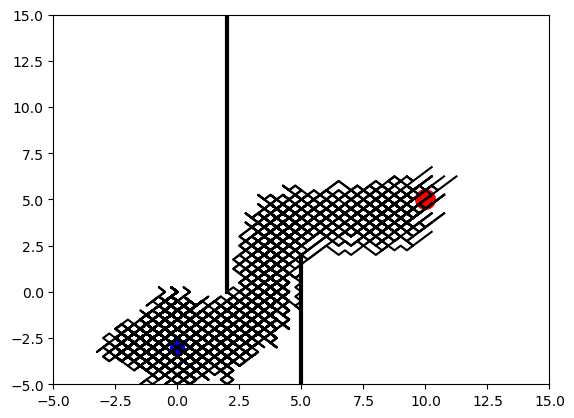

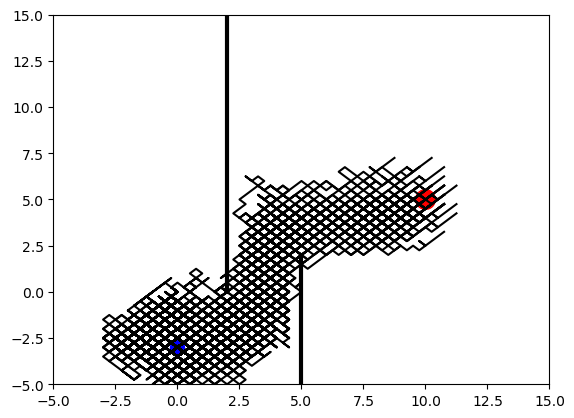

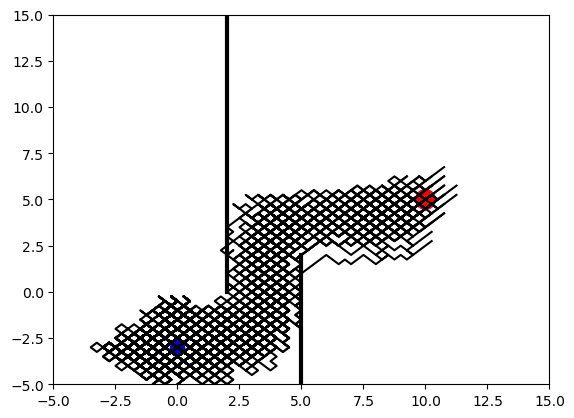

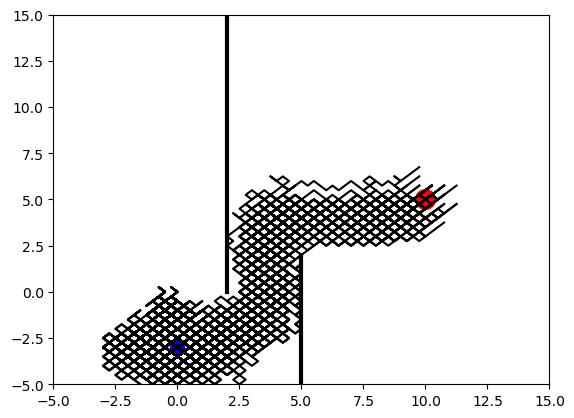

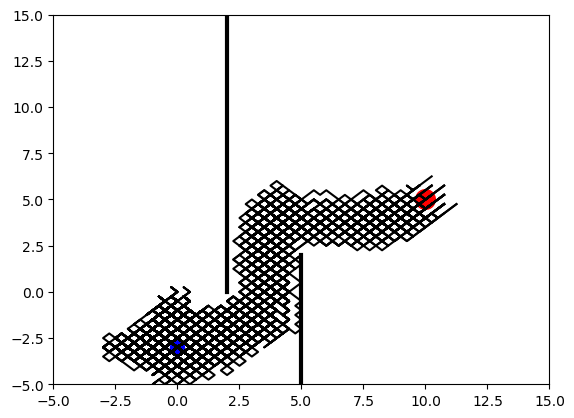

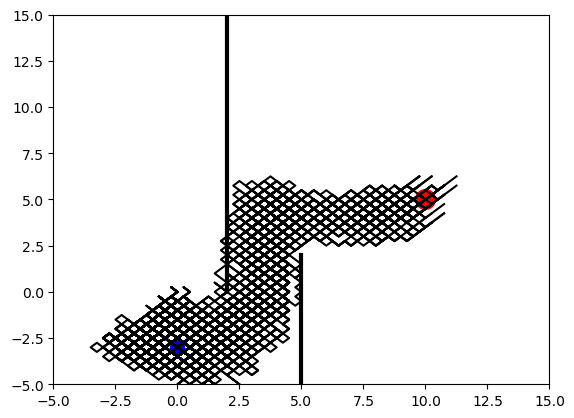

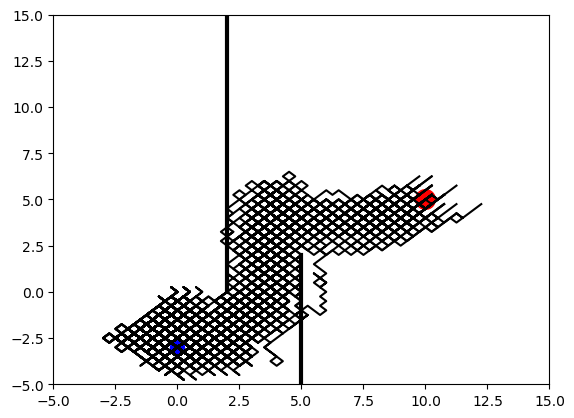

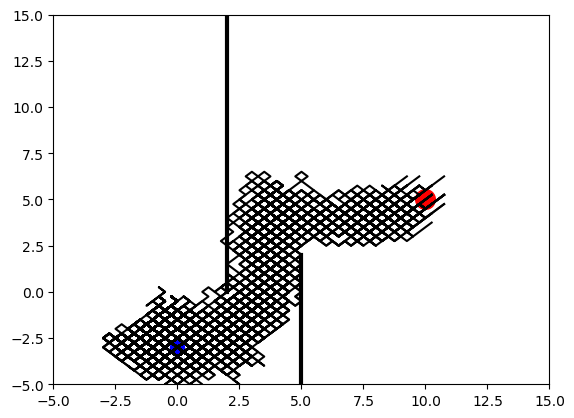

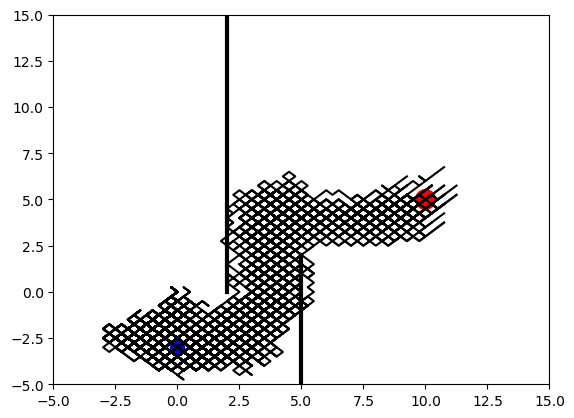

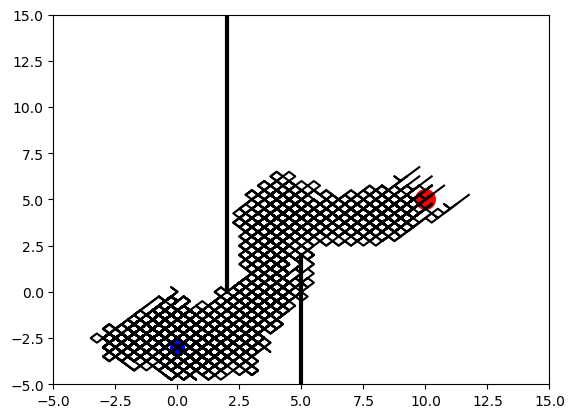

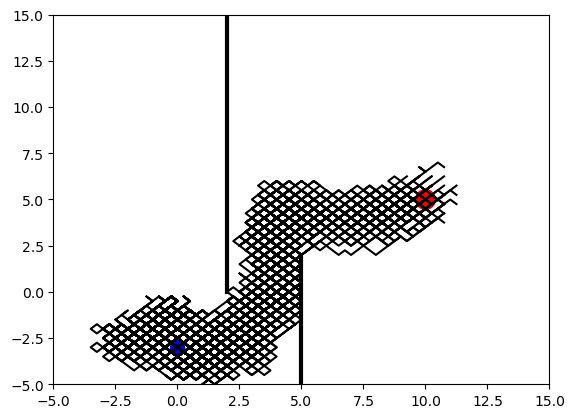

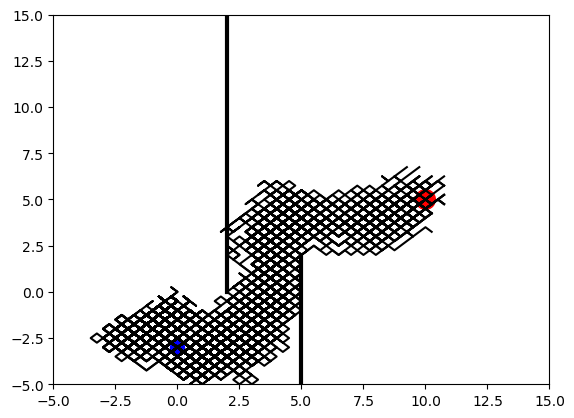

In [6]:
n_runs = 1
fitness_max_mine = np.zeros((n_runs, N_GENERATIONS))
for i in range(n_runs):
    ga = GA(DNA_size=DNA_SIZE, DNA_bound=DIRECTION_BOUND,
        cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)
    for generation in range(N_GENERATIONS):
        lx, ly = ga.DNA2product(ga.pop, N_MOVES, START_POINT)
        fitness = ga.get_fitness(lx, ly, GOAL_POINT, OBSTACLE_LINE)
        ga.evolve(fitness)
        fitness_max_mine[i,generation] = fitness.max()
        if i==0: #and generation%20 == 0:
            env.plotting(lx, ly, save=False)

Here, we see that the genes learn to go even below the right obstacle to get around it. Comparing the changes that have been made to the original code by Morvan Zhou over 20 runs:


# Travelling Salesman Problem
The [Travelling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is a very well known NP-hard combinatorial optimization problem, which asks: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

For this problem, the chromosome has been selected to be the set of cities. Therefore, chromosome sequence is $[4,2,5,1,3]$ then the order of cities travelled is $4\rightarrow 2\rightarrow 5\rightarrow 1\rightarrow 3\rightarrow 4$.

In my implementation, I only edit the crossover function from the implementation of Morvhan Zhou. In the original implementation, during crossover a random set of genes is selected from one parent, and the cities in those genes are then ordered according to the other parent, and then the two are concatenated to get the offspring. This is depectied below:
$$P_1 = [x_1, x_2, x_3, x_4, x_5]$$
$$P_2 = [x_5, x_4, x_3, x_2, x_1]$$
$$\text{random genes selected from }P_1 = [x_1, x_2, x_4]$$
$$\text{Child, } C_{12} = [x_3, x_5, x_4, x_2, x_1]$$

In my implementation, instead of concatenating in the end, instead we conserve the indexes in the child, but only reorder them according to the other parent. The idea is that the parents may have been selected becuase of their high fitness in terms of having groups of cities traversed together. We would like to keep these groups intact, by preserving spatial relationships. Therefore, using the above example, in my implementation the child is:
$$C'_{12} = [x_4, x_2, x_3, x_1, x_5]$$
Here we see that for example if $\{x_1,x_2,x_3\}$ was a good subset of close cities, they would remain close even after crossover.

In [10]:
import os
N_CITIES = 20  # DNA size
CROSS_RATE = 0.1
MUTATE_RATE = 0.02
POP_SIZE = 300
N_GENERATIONS = 350


class GA(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size, ):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size

        self.pop = np.vstack([np.random.permutation(DNA_size) for _ in range(pop_size)])

    def translateDNA(self, DNA, city_position):     # get cities' coord in order
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        for i, d in enumerate(DNA):
            city_coord = city_position[d]
            line_x[i, :] = city_coord[:, 0]
            line_y[i, :] = city_coord[:, 1]
        return line_x, line_y

    def get_fitness(self, line_x, line_y):
        total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
        for i, (xs, ys) in enumerate(zip(line_x, line_y)):
            total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))
        fitness = np.exp(self.DNA_size * 2 / total_distance)
        return fitness, total_distance

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)                      # select another individual from pop
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(bool)   # choose crossover points
            keep_city = parent[~cross_points]                                      # find the city number
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            parent[cross_points] = swap_city
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def evolve(self, fitness):
        pop = self.select(fitness)
        pop_copy = pop.copy()
        for parent in pop:  # for every parent
            child = self.crossover(parent, pop_copy)
            child = self.mutate(child)
            parent[:] = child
        self.pop = pop


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = np.random.rand(n_cities, 2)
        plt.ion()
        self.iter = 0

    def plotting(self, lx, ly, total_d, save=True):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        if save:
            # Ensure the directory exists
            os.makedirs('img_output/travelling_salesman', exist_ok=True)
            # Save the figure in the correct folder
            plt.savefig(f'img_output/travelling_salesman/travelling_salesman_{self.iter:03d}.png')    
        if self.iter % 50 == 0:
            plt.show()
    
        self.iter += 1
        

In [11]:
env = TravelSalesPerson(N_CITIES)

Gen: 0 | best fit: 447.59


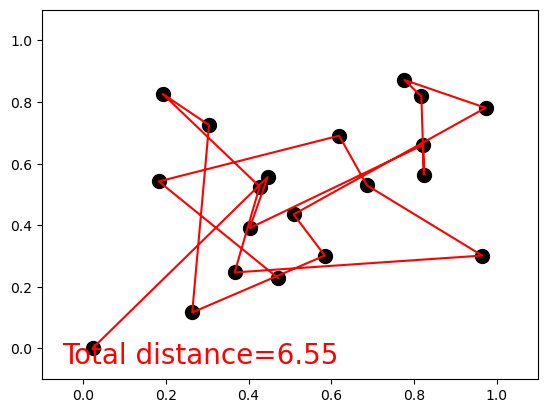

Gen: 20 | best fit: 4216.88
Gen: 40 | best fit: 8072.93


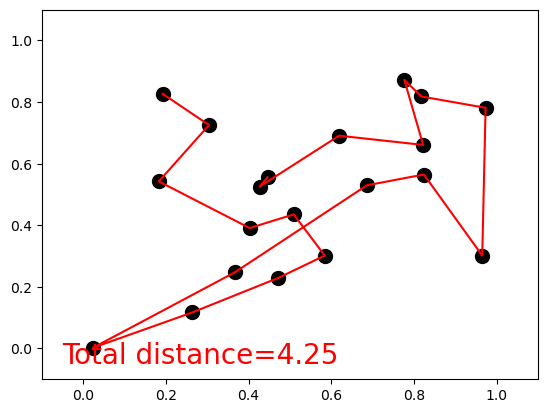

Gen: 60 | best fit: 13899.29
Gen: 80 | best fit: 16062.97
Gen: 100 | best fit: 21710.08


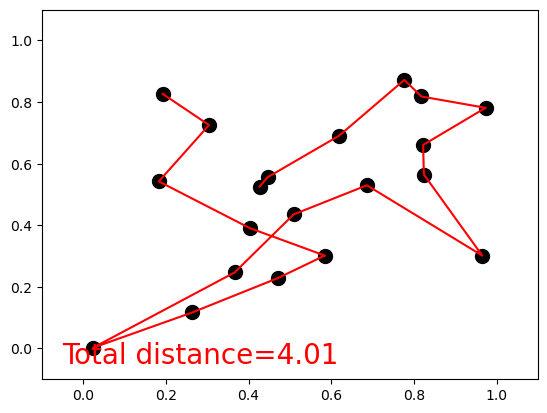

Gen: 120 | best fit: 18910.77
Gen: 140 | best fit: 18910.77


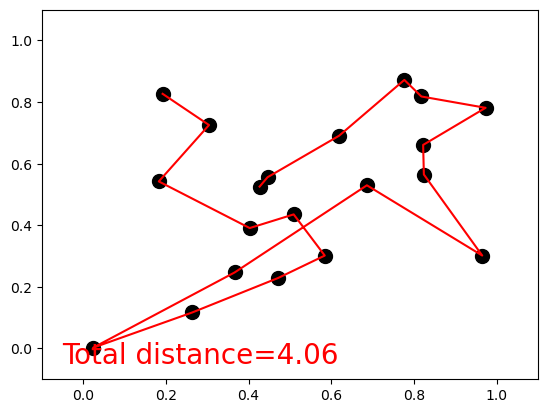

Gen: 160 | best fit: 18910.77
Gen: 180 | best fit: 18910.77
Gen: 200 | best fit: 18910.77


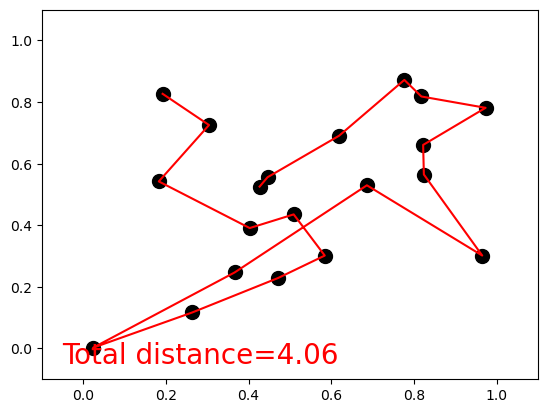

Gen: 220 | best fit: 18910.77
Gen: 240 | best fit: 20361.15


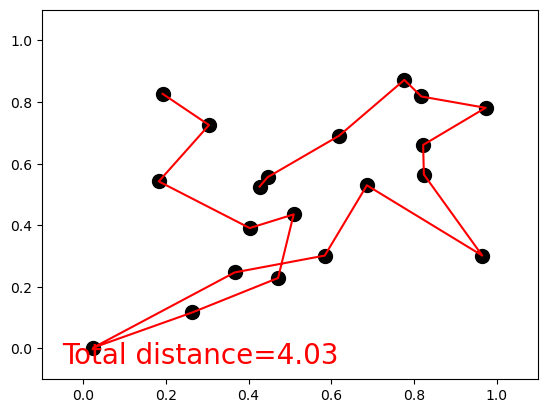

Gen: 260 | best fit: 21675.57
Gen: 280 | best fit: 24807.55
Gen: 300 | best fit: 24807.55


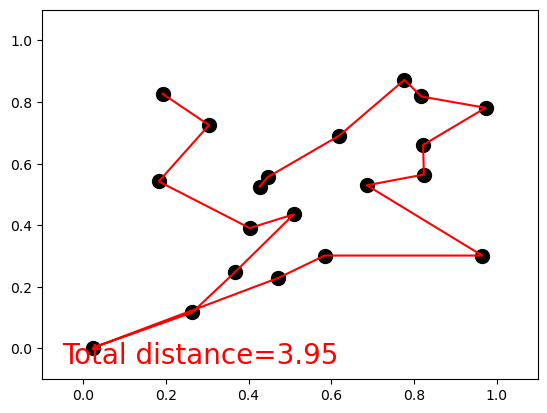

Gen: 320 | best fit: 24807.55
Gen: 340 | best fit: 26241.78


KeyboardInterrupt: 

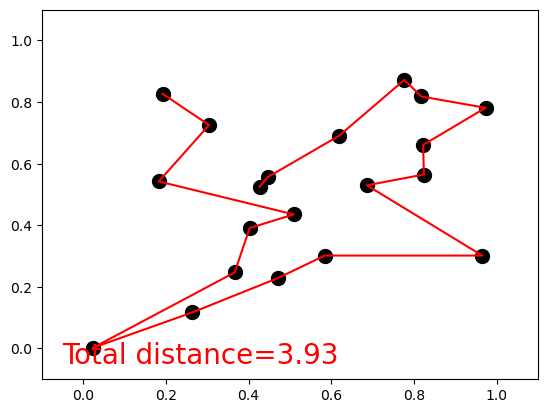

In [12]:
n_runs = 30
fitness_max_mine = np.zeros((n_runs, N_GENERATIONS))
for i in range(n_runs):
    ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)
    for generation in range(N_GENERATIONS):
        lx, ly = ga.translateDNA(ga.pop, env.city_position)
        fitness, total_distance = ga.get_fitness(lx, ly)
        ga.evolve(fitness)
        best_idx = np.argmax(fitness)
        fitness_max_mine[i, generation] = total_distance[best_idx]
        if i==0:
            if generation%20==0: print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
            env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx], save=True)

Again we see that even a small change in the implementation can lead to better and faster solutions in the case of genetic algorithms.